In [29]:
import scipy.io
import numpy as np
from sklearn.metrics import auc
import pingouin as pg
import pandas as pd
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM

In [30]:
hc_data_path = '/Users/jk1/unige_onedrive/OneDrive - unige.ch/BCT/atlas_BNA/BNA_240_flipped_N32_retroicor_SBB4_prop_bin_window/HC/CharPath240_binwin_HC.mat'
st_data_path = '/Users/jk1/unige_onedrive/OneDrive - unige.ch/BCT/atlas_BNA/BNA_240_flipped_N32_retroicor_SBB4_prop_bin_window/ST/CharPath240_binwin.mat'

In [31]:
minimum_connectivity_threshold = 0.3

In [32]:
hc_data_mat = scipy.io.loadmat(hc_data_path)
st_data_mat = scipy.io.loadmat(st_data_path)

In [33]:
# converting matlab mat to arrays
# transposing to have shape (n_subj, n_thresholds)
hc_glob_eff = np.vstack(hc_data_mat['GlobEfficiency'][0][0]).T
st0_glob_eff = np.vstack(np.vstack(st_data_mat['GlobEfficiency'][0][0])[0][0]).T
st1_glob_eff = np.vstack(np.vstack(st_data_mat['GlobEfficiency'][0][0])[1][0]).T
st2_glob_eff = np.vstack(np.vstack(st_data_mat['GlobEfficiency'][0][0])[2][0]).T

In [34]:
# correct for missing values - (pt1 TP1, pt5 Tp2, Pt13 (=pt17) TP3)
n_bins = st0_glob_eff.shape[1]
st0_glob_eff = np.insert(st0_glob_eff, 0, np.full((n_bins), np.NaN), axis=0)
st1_glob_eff = np.insert(st1_glob_eff, 4, np.full((n_bins), np.NaN), axis=0)
st2_glob_eff = np.insert(st2_glob_eff, 12, np.full((n_bins), np.NaN), axis=0)

In [35]:
n_hc = hc_glob_eff.shape[0]
n_st = st0_glob_eff.shape[0]

In [36]:
# only analyse thresholds above minimum_connectivity_threshold
minimum_connectivity_threshold_index = int(minimum_connectivity_threshold*10 - 1)
connectivity_thresholds = np.arange(minimum_connectivity_threshold, 1.1, 0.1)

In [37]:
def glob_eff_auc_per_subject(subjects_glob_eff, connectivity_thresholds, minimum_connectivity_threshold_index):
    # compute global efficiency AUC over connectivity_thresholds for each subject
    subjects_glob_eff_auc = []
    for subj_idx in range(subjects_glob_eff.shape[0]):
        subjects_glob_eff_auc.append(
            auc(connectivity_thresholds,
                subjects_glob_eff[subj_idx, minimum_connectivity_threshold_index:])
        )
    return subjects_glob_eff_auc

In [38]:
hc_glob_eff_auc = glob_eff_auc_per_subject(hc_glob_eff, connectivity_thresholds, minimum_connectivity_threshold_index)
st0_glob_eff_auc = glob_eff_auc_per_subject(st0_glob_eff, connectivity_thresholds, minimum_connectivity_threshold_index)
st1_glob_eff_auc = glob_eff_auc_per_subject(st1_glob_eff, connectivity_thresholds, minimum_connectivity_threshold_index)
st2_glob_eff_auc = glob_eff_auc_per_subject(st2_glob_eff, connectivity_thresholds, minimum_connectivity_threshold_index)

In [39]:
# Compare to healthy subjects using one-way ANOVA
f_oneway(hc_glob_eff_auc, st0_glob_eff_auc, st1_glob_eff_auc, st2_glob_eff_auc)


F_onewayResult(statistic=nan, pvalue=nan)

In [40]:
# glob_eff_auc_df = pd.DataFrame(hc_glob_eff_auc, st0_glob_eff_auc, st1_glob_eff_auc, st2_glob_eff_auc,
#                                columns=['hc', 'st0', 'st1', 'st2'])
all_subj_idx = np.arange(n_hc + n_st)
hc_idx = all_subj_idx[:n_hc]
st_idx = all_subj_idx[n_hc:]

columns = ['subject', 'glob_eff_auc', 'group', 'timepoint']
hc_glob_eff_auc_df = pd.DataFrame([hc_idx, hc_glob_eff_auc, np.repeat('hc', n_hc), np.repeat(0, n_hc)]).T
st0_glob_eff_auc_df = pd.DataFrame([st_idx, st0_glob_eff_auc, np.repeat('st', n_st), np.repeat(0, n_st)]).T
st1_glob_eff_auc_df = pd.DataFrame([st_idx, st1_glob_eff_auc, np.repeat('st', n_st), np.repeat(1, n_st)]).T
st2_glob_eff_auc_df = pd.DataFrame([st_idx, st2_glob_eff_auc, np.repeat('st', n_st), np.repeat(2, n_st)]).T

glob_eff_auc_df = pd.concat([hc_glob_eff_auc_df,st0_glob_eff_auc_df, st1_glob_eff_auc_df, st2_glob_eff_auc_df],
                            ignore_index=True)
all_st_glob_eff_auc_df = pd.concat([st0_glob_eff_auc_df, st1_glob_eff_auc_df, st2_glob_eff_auc_df],
                            ignore_index=True)
glob_eff_auc_df.columns = columns
all_st_glob_eff_auc_df.columns = columns

# convert auc to numeric
glob_eff_auc_df['glob_eff_auc'] = glob_eff_auc_df['glob_eff_auc'].astype('float')
all_st_glob_eff_auc_df['glob_eff_auc'] = all_st_glob_eff_auc_df['glob_eff_auc'].astype('float')

# convert timepoint to numeric
glob_eff_auc_df['timepoint'] = glob_eff_auc_df['timepoint'].astype('float')
all_st_glob_eff_auc_df['timepoint'] = all_st_glob_eff_auc_df['timepoint'].astype('float')


glob_eff_auc_df.head()

,subject,glob_eff_auc,group,timepoint
0,0,0.305002,hc,0.0
1,1,0.298386,hc,0.0
2,2,0.302245,hc,0.0
3,3,0.299333,hc,0.0
4,4,0.305663,hc,0.0


In [41]:
# without AUC data reduction

hc_glob_eff_df = pd.DataFrame(data=hc_glob_eff)
hc_glob_eff_df['subject'] = hc_idx
hc_glob_eff_df = hc_glob_eff_df.melt(id_vars=['subject'], var_name='density_bin', value_name='glob_eff')
hc_glob_eff_df['timepoint'] = 0
hc_glob_eff_df['group'] = 'hc'

st0_glob_eff_df = pd.DataFrame(data=st0_glob_eff)
st0_glob_eff_df['subject'] = st_idx
st0_glob_eff_df = st0_glob_eff_df.melt(id_vars=['subject'], var_name='density_bin', value_name='glob_eff')
st0_glob_eff_df['timepoint'] = 0
st0_glob_eff_df['group'] = 'st'

st1_glob_eff_df = pd.DataFrame(data=st1_glob_eff)
st1_glob_eff_df['subject'] = st_idx
st1_glob_eff_df = st1_glob_eff_df.melt(id_vars=['subject'], var_name='density_bin', value_name='glob_eff')
st1_glob_eff_df['timepoint'] = 1
st1_glob_eff_df['group'] = 'st'

st2_glob_eff_df = pd.DataFrame(data=st2_glob_eff)
st2_glob_eff_df['subject'] = st_idx
st2_glob_eff_df = st2_glob_eff_df.melt(id_vars=['subject'], var_name='density_bin', value_name='glob_eff')
st2_glob_eff_df['timepoint'] = 2
st2_glob_eff_df['group'] = 'st'

glob_eff_df = pd.concat([hc_glob_eff_df,st0_glob_eff_df, st1_glob_eff_df, st2_glob_eff_df],
                            ignore_index=True)

In [42]:
# convert auc to numeric
glob_eff_df['glob_eff'] = glob_eff_df['glob_eff'].astype('float')
glob_eff_df['density_bin'] = glob_eff_df['density_bin'].astype('float')

In [43]:
# make density bins correspond to initial nomenclature (1-10)
glob_eff_df['density_bin'] += 1

# threshold bins at [0.3-1]
glob_eff_df = glob_eff_df[glob_eff_df['density_bin'] >= 3]

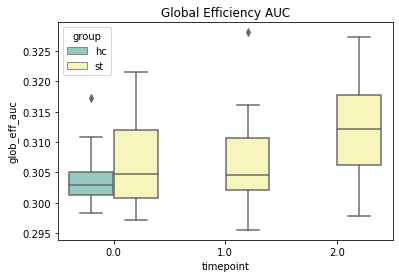

In [44]:
ax = sns.boxplot(x="timepoint", y="glob_eff_auc", hue="group", data=glob_eff_auc_df, palette="Set3")
ax.set_title('Global Efficiency AUC')
plt.show()

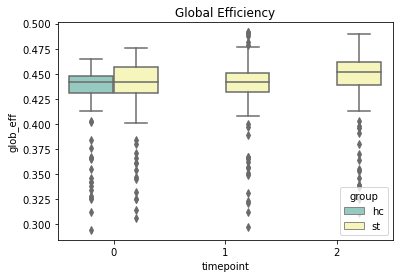

In [45]:
ax = sns.boxplot(x="timepoint", y="glob_eff", hue="group", data=glob_eff_df, palette="Set3")
ax.set_title('Global Efficiency')
plt.show()

In [56]:
pg.rm_anova(data=glob_eff_auc_df, dv='glob_eff_auc', subject='subject', within=['group'], detailed=True)


/Users/jk1/opt/anaconda3/envs/resilience_stroke/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/jk1/opt/anaconda3/envs/resilience_stroke/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/jk1/opt/anaconda3/envs/resilience_stroke/lib/python3.8/site-packages/pandas/core/frame.py:8522: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/jk1/opt/anaconda3/envs/resilience_stroke/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/jk1/opt/anaconda3/envs/resilience_stroke/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,Source,SS,DF,MS,F,p-unc,np2,eps
0,group,0.000231,1,0.000231,-2.241636,1.0,-0.175699,1.0
1,Error,-0.001548,15,-0.000103,NaN,NaN,NaN,NaN


In [48]:
pg.rm_anova(data=all_st_glob_eff_auc_df, dv='glob_eff_auc', subject='subject', within=['timepoint'], detailed=True)


/Users/jk1/opt/anaconda3/envs/resilience_stroke/lib/python3.8/site-packages/pingouin/distribution.py:950: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d


,Source,SS,DF,MS,F,p-unc,np2,eps
0,timepoint,0.000340,2,0.000170,6.746407,0.004733,0.359877,0.88712
1,Error,0.000604,24,0.000025,NaN,NaN,NaN,NaN


In [49]:
aov = pg.mixed_anova(dv='glob_eff_auc', within='timepoint', between='group', subject='subject', data=glob_eff_auc_df)
# Pretty printing of ANOVA summary
pg.print_table(aov)


ANOVA SUMMARY

Source           SS    DF1    DF2      MS        F    p-unc    np2      eps
-----------  ------  -----  -----  ------  -------  -------  -----  -------
group         0.000      1     27   0.000    1.435    0.241  0.050  nan
timepoint     0.000      2     54   0.000  -53.023    1.000  2.038    0.887
Interaction  -0.000      2     54  -0.000   13.042    0.000  0.326  nan



/Users/jk1/opt/anaconda3/envs/resilience_stroke/lib/python3.8/site-packages/pingouin/distribution.py:950: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d


In [50]:
# # conduct ANOVA using mixedlm
# my_model_fit = smf.mixedlm("glob_eff_auc ~ timepoint", glob_eff_auc_df, groups=glob_eff_auc_df["group"]).fit()
# # get random effects
# my_model_fit.random_effects
# # get fixed effects
# my_model_fit.summary()

In [51]:
# glob_eff_auc_df.to_csv('glob_eff_auc_df.csv', index=False)
#

In [52]:
# glob_eff_df.to_csv('glob_eff_df.csv', index=False)